# Análisis exploratorio de datos: gasolineras madrileñas

## **1. Variables:**

El conjunto de datos utilizado cuenta con las siguientes variables: 

* **station_id** : Identificador único de la gasolinera
* **name** : Compañia de la gasolinera
* **address** : Dirección
* **town** : Ciudad
* **zip_code** : Código Postal
* **longitude** : Longitud
* **latitude** : Latitud
* **road_side** :(N) Ninguna, (D) Derecha, (I) Izquierda
* **restriction**: (P) Pública, (R) Restringida
* **sender** :(OM) Operador mayorista, (dm) Distribuidor minorista
* **schedule** : Horario de apertura
* **region_id** : Identificador de la región en España
* **province_id** : Identificador de la provincia en España
* **municipality_id** : Identificador de la provincia en España
* **region_name** : Nombre de la región
* **province_name**: Nombre de la provincia
* **municipality_name**: Nombre del municipio
* **date** : Fecha
* **gasoline_95E5** : gasolina 95 E5
* **gasoline_95E5_premium** : gasolina 95 E5 premium
* **gasoline_95E10** : gasolina 95 E10 
* **gasoline_98E5** : gasolina 98 E5 
* **gasoline_98E10** : gasolina 98 E10 
* **diesel_A** :  Diesel A
* **diesel_B** :  Diesel B
* **diesel_premium** :  Diesel premium
* **bioetanol** :  Bioetanol
* **biodiesel** : Biodiesel 
* **lpg** : LPG
* **cng** : CNG
* **lng** : LNG
* **hydrogen** : Hidrógeno

Para poder realizar algunas de las visualizaciones hemos añadido las siguientes variables:

* **vivienda_agua_electricidad_combustibles** : CPI para vivienda, agua, electricidad y combustibles en esa fecha.
* **Precios ajustados** : Hemos ajustado las columnas de precios de combustibles en función de la inflación
* **min_distance** : Distancia a la gasolinera más cercana
* **district** : Distrito de Madrid
* **neighbourhood** : Barrio de Madrid
* **schedule_parsed** : Horario de apertura tipificado
* **name_parsed** : Compañia de la gasolinera tipificado
* **num_combustibles** : Número de combustibles que tienen en la gasolinera.

## **2. Objetivo:**
En este notebook se tratrá de observar la trayectoria de los precios que se tienen de las gasolineras madrileñas junto con otros aspectos importantes para estos.



## **3. EDA:**

### Librerías

In [18]:
import json
import math
from itertools import count
from urllib.parse import urlencode
from datetime import datetime, timedelta, date

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import pickle

pd.options.display.max_columns = None
pd.options.display.max_rows = 6

### Array de combustibles

In [19]:
# Array de combustibles
products = ["gasoline_95E5",
            "gasoline_95E5_premium",
            "gasoline_98E5",
            #"gasoline_98E10",
            "diesel_A",
            "diesel_B",
            "diesel_premium",
            #"bioetanol",
            "biodiesel",
            "lpg",
            "cng",
            "lng"]
            #"hydrogen"]

#Array para los combustibles con el precio ajustado
products_adj = [x + '_adj' for x in products]

### Diccionarios

In [20]:
# Diccionario con los nombres de los combustibles tipificados
products_titles = {
    "gasoline_95E5" : "gasolina 95 E5",
    "gasoline_95E5_premium" : "gasolina 95 E5 premium",
    "gasoline_98E5" : "gasolina 98 E5",
    "gasoline_98E10" : "gasolina 98 E10",
    "diesel_A" : "diesel A",
    "diesel_B" : "diesel B",
    "diesel_premium"  : "diesel premium",
    "bioetanol" : "bioetanol",
    "biodiesel" : "biodiesel",
    "lpg" : "LPG",
    "cng" : "CNG",
    "lng" :"LNG",
    "hydrogen" : "hidrógeno"}

# Diccionario para la paleta de colores en función de la compañia.
name_colors = {
    "OTROS"     : '#%02x%02x%02x' % (89,90,94),
    "BALLENOIL" : '#%02x%02x%02x' % (0,147,203),
    "BP"        : '#%02x%02x%02x' % (17,138,40),
    "CARREFOUR" : '#%02x%02x%02x' % (20,73,146),
    "CEPSA"     : '#%02x%02x%02x' % (199,37,27),
    "GALP"      : '#%02x%02x%02x' % (176,42,12),
    "NATURGY "  : '#%02x%02x%02x' % (210,28,1),
    "PLENOIL"   : '#%02x%02x%02x' % (0,42,104),
    "REPSOL"    : '#%02x%02x%02x' % (253,137,6),
    "SHELL"     : '#%02x%02x%02x' % (251, 199, 11)}

In [21]:
# Array para la paleta de colores en función del combustible.
palette =["#f44336",
          "#e81e63",
          "#9c27b0",
          "#673ab7",
          "#3f51b5",
          "#2196f3",
          "#03a9f4",
          "#00bcd4",
          "#009688",
          "#4caf50",
          "#8bc34a",
          "#cddc39",
          "#ffeb3b"]

### Importar datos procesados y .geojson

In [22]:
# Importamos los datos para cada combustible
with open("data/output/diccionario_df_productos", 'rb') as f:
    dict_df_products = pickle.load(f)
    
# Importamos los datos ya procesados
with open("data/output/df_parsed", 'rb') as f:
    df_parsed = pickle.load(f)
    
# Importamos el .geojson que contiene las coordenadas de los distritos de Madrid
with open('data/raw/madrid-city.geojson', 'r') as f:
    city_border = json.load(f)
    
# Importamos el .geojson que contiene las coordenadas de los barrios de Madrid
with open('data/raw/madrid-neighbourhoods.geojson', 'r') as f:
    neighbourhood_borders = json.load(f)
    
# Importamos el .csv que contiene los nombres de los barrios de Madrid    
neighbourhood_names = pd.read_csv('data/raw/madrid-neighbourhoods-names.csv')

### Comprobamos los datos importados

In [23]:
for product in products:
    print(product + ":")
    display(dict_df_products[product])

gasoline_95E5:


station_id       date     name                 address zip_code  \
0            2909 2021-01-02   REPSOL  CALLE CEA BERMUDEZ, 32    28003   
1            2909 2021-01-03   REPSOL  CALLE CEA BERMUDEZ, 32    28003   
2            2909 2021-01-04   REPSOL  CALLE CEA BERMUDEZ, 32    28003   
...           ...        ...      ...                     ...      ...   
82712       15166 2021-12-29  PLENOIL  CALLE SAN DALMACIO, 13    28000   
82713       15166 2021-12-30  PLENOIL  CALLE SAN DALMACIO, 13    28000   
82714       15166 2021-12-31  PLENOIL  CALLE SAN DALMACIO, 13    28000   

       longitude  latitude road_side restriction sender  schedule  \
0      -3.709639  40.43900         D           P     dm  L-D: 24H   
1      -3.709639  40.43900         D           P     dm  L-D: 24H   
2      -3.709639  40.43900         D           P     dm  L-D: 24H   
...          ...       ...       ...         ...    ...       ...   
82712  -3.694917  40.34325         D           P     dm  L-D: 24H   
82713  -3.694917  40.34325         D           P     dm  L-D: 24H   
82714  -3.694917  40.34325         D           P     dm  L-D: 24H   

       gasoline_95E5  gasoline_95E5_premium  gasoline_95E10  gasoline_98E5  \
0              1.299                    0.0             0.0          1.439   
1              1.299                    0.0             0.0          1.439   
2              1.299                    0.0             0.0          1.439   
...              ...                    ...             ...            ...   
82712          1.347                    0.0             0.0          0.000   
82713          1.347                    0.0             0.0          0.000   
82714          1.347                    0.0             0.0          0.000   

       gasoline_98E10  diesel_A  diesel_B  diesel_premium  bioetanol  \
0                 0.0     1.169       0.0           1.249        0.0   
1                 0.0     1.169       0.0           1.249        0.0   
2                 0.0     1.169       0.0           1.249        0.0   
...               ...       ...       ...             ...        ...   
82712             0.0     1.227       0.0           0.000        0.0   
82713             0.0     1.227       0.0           0.000        0.0   
82714             0.0     1.227       0.0           0.000        0.0   

       biodiesel  lpg  cng  lng  hydrogen  \
0            0.0  0.0  0.0  0.0       0.0   
1            0.0  0.0  0.0  0.0       0.0   
2            0.0  0.0  0.0  0.0       0.0   
...          ...  ...  ...  ...       ...   
82712        0.0  0.0  0.0  0.0       0.0   
82713        0.0  0.0  0.0  0.0       0.0   
82714        0.0  0.0  0.0  0.0       0.0   

       vivienda_agua_electricidad_combustibles  gasoline_95E5_adj  \
0                                       95.346           1.299000   
1                                       95.346           1.299000   
2                                       95.346           1.299000   
...                                        ...                ...   
82712                                  112.736           1.592677   
82713                                  112.736           1.592677   
82714                                  112.736           1.592677   

       gasoline_95E5_premium_adj  gasoline_98E5_adj  diesel_A_adj  \
0                            0.0              1.439      1.169000   
1                            0.0              1.439      1.169000   
2                            0.0              1.439      1.169000   
...                          ...                ...           ...   
82712                        0.0              0.000      1.450791   
82713                        0.0              0.000      1.450791   
82714                        0.0              0.000      1.450791   

       diesel_B_adj  diesel_premium_adj  biodiesel_adj  lpg_adj  cng_adj  \
0               0.0               1.249            0.0      0.0      0.0   
1               0.0               1.249 

gasoline_95E5_premium:


station_id       date    name                 address zip_code  \
1065         2914 2021-01-02  REPSOL  CR N-4     P.K. 6,70 I    28041   
1066         2914 2021-01-03  REPSOL  CR N-4     P.K. 6,70 I    28041   
1067         2914 2021-01-04  REPSOL  CR N-4     P.K. 6,70 I    28041   
...           ...        ...     ...                     ...      ...   
59282       11538 2021-12-29  REPSOL         CALLE ABETAL, 8    28050   
59283       11538 2021-12-30  REPSOL         CALLE ABETAL, 8    28050   
59284       11538 2021-12-31  REPSOL         CALLE ABETAL, 8    28050   

       longitude   latitude road_side restriction sender  schedule  \
1065   -3.693833  40.367000         I           P     dm  L-D: 24H   
1066   -3.693833  40.367000         I           P     dm  L-D: 24H   
1067   -3.693833  40.367000         I           P     dm  L-D: 24H   
...          ...        ...       ...         ...    ...       ...   
59282  -3.661944  40.501389         D           P     OM  L-D: 24H   
59283  -3.661944  40.501389         D           P     OM  L-D: 24H   
59284  -3.661944  40.501389         D           P     OM  L-D: 24H   

       gasoline_95E5  gasoline_95E5_premium  gasoline_95E10  gasoline_98E5  \
1065           1.299                  1.339             0.0          1.439   
1066           1.299                  1.339             0.0          1.439   
1067           1.299                  1.339             0.0          1.439   
...              ...                    ...             ...            ...   
59282          1.559                  1.579             0.0          1.699   
59283          1.565                  1.585             0.0          1.705   
59284          1.569                  1.589             0.0          1.719   

       gasoline_98E10  diesel_A  diesel_B  diesel_premium  bioetanol  \
1065              0.0     1.179       0.0           1.209        0.0   
1066              0.0     1.179       0.0           1.209        0.0   
1067              0.0     1.179       0.0           1.209        0.0   
...               ...       ...       ...             ...        ...   
59282             0.0     1.429       0.0           1.519        0.0   
59283             0.0     1.429       0.0           1.519        0.0   
59284             0.0     1.439       0.0           1.539        0.0   

       biodiesel    lpg  cng  lng  hydrogen  \
1065         0.0  0.000  0.0  0.0       0.0   
1066         0.0  0.000  0.0  0.0       0.0   
1067         0.0  0.000  0.0  0.0       0.0   
...          ...    ...  ...  ...       ...   
59282        0.0  0.849  0.0  0.0       0.0   
59283        0.0  0.849  0.0  0.0       0.0   
59284        0.0  0.849  0.0  0.0       0.0   

       vivienda_agua_electricidad_combustibles  gasoline_95E5_adj  \
1065                                    95.346           1.299000   
1066                                    95.346           1.299000   
1067                                    95.346           1.299000   
...                                        ...                ...   
59282                                  112.736           1.843343   
59283                                  112.736           1.850438   
59284                                  112.736           1.855167   

       gasoline_95E5_premium_adj  gasoline_98E5_adj  diesel_A_adj  \
1065                    1.339000           1.439000      1.179000   
1066                    1.339000           1.439000      1.179000   
1067                    1.339000           1.439000      1.179000   
...                          ...                ...           ...   
59282                   1.866991           2.008878      1.689633   
59283                   1.874086           2.015972      1.689633   
59284                   1.878815           2.032526      1.701457   

       diesel_B_adj  diesel_premium_adj  biodiesel_adj   lpg_adj  cng_adj  \
1065            0.0            1.209000            0.0  0.000000      0.0   
1066            0.0   

gasoline_98E5:


station_id       date              name                        address  \
0            2909 2021-01-02            REPSOL         CALLE CEA BERMUDEZ, 32   
1            2909 2021-01-03            REPSOL         CALLE CEA BERMUDEZ, 32   
2            2909 2021-01-04            REPSOL         CALLE CEA BERMUDEZ, 32   
...           ...        ...               ...                            ...   
82002       15107 2021-12-29  BP MAYORAZGO 365  CALLE SIERRA DE LA DEMANDA, 2   
82003       15107 2021-12-30  BP MAYORAZGO 365  CALLE SIERRA DE LA DEMANDA, 2   
82004       15107 2021-12-31  BP MAYORAZGO 365  CALLE SIERRA DE LA DEMANDA, 2   

      zip_code  longitude   latitude road_side restriction sender  schedule  \
0        28003  -3.709639  40.439000         D           P     dm  L-D: 24H   
1        28003  -3.709639  40.439000         D           P     dm  L-D: 24H   
2        28003  -3.709639  40.439000         D           P     dm  L-D: 24H   
...        ...        ...        ...       ...         ...    ...       ...   
82002    28031  -3.633750  40.370111         I           P     dm  L-D: 24H   
82003    28031  -3.633750  40.370111         I           P     dm  L-D: 24H   
82004    28031  -3.633750  40.370111         I           P     dm  L-D: 24H   

       gasoline_95E5  gasoline_95E5_premium  gasoline_95E10  gasoline_98E5  \
0              1.299                    0.0             0.0          1.439   
1              1.299                    0.0             0.0          1.439   
2              1.299                    0.0             0.0          1.439   
...              ...                    ...             ...            ...   
82002          1.459                    0.0             0.0          1.579   
82003          1.459                    0.0             0.0          1.579   
82004          1.459                    0.0             0.0          1.579   

       gasoline_98E10  diesel_A  diesel_B  diesel_premium  bioetanol  \
0                 0.0     1.169       0.0           1.249        0.0   
1                 0.0     1.169       0.0           1.249        0.0   
2                 0.0     1.169       0.0           1.249        0.0   
...               ...       ...       ...             ...        ...   
82002             0.0     1.369       0.0           1.429        0.0   
82003             0.0     1.369       0.0           1.429        0.0   
82004             0.0     1.369       0.0           1.429        0.0   

       biodiesel  lpg  cng  lng  hydrogen  \
0            0.0  0.0  0.0  0.0       0.0   
1            0.0  0.0  0.0  0.0       0.0   
2            0.0  0.0  0.0  0.0       0.0   
...          ...  ...  ...  ...       ...   
82002        0.0  0.0  0.0  0.0       0.0   
82003        0.0  0.0  0.0  0.0       0.0   
82004        0.0  0.0  0.0  0.0       0.0   

       vivienda_agua_electricidad_combustibles  gasoline_95E5_adj  \
0                                       95.346           1.299000   
1                                       95.346           1.299000   
2                                       95.346           1.299000   
...                                        ...                ...   
82002                                  112.736           1.725105   
82003                                  112.736           1.725105   
82004                                  112.736           1.725105   

       gasoline_95E5_premium_adj  gasoline_98E5_adj  diesel_A_adj  \
0                            0.0           1.439000       1.16900   
1                            0.0           1.439000       1.16900   
2                            0.0           1.439000       1.16900   
...                          ...                ...           ...   
82002                        0.0           1.866991       1.61869   
82003                        0.0           1.866991       1.61869   
82004                        0.0           1.866991       1.61869   

       diesel_B_adj  diesel_premium_adj  biodiesel_adj  

diesel_A:


station_id       date     name                 address zip_code  \
0            2909 2021-01-02   REPSOL  CALLE CEA BERMUDEZ, 32    28003   
1            2909 2021-01-03   REPSOL  CALLE CEA BERMUDEZ, 32    28003   
2            2909 2021-01-04   REPSOL  CALLE CEA BERMUDEZ, 32    28003   
...           ...        ...      ...                     ...      ...   
82712       15166 2021-12-29  PLENOIL  CALLE SAN DALMACIO, 13    28000   
82713       15166 2021-12-30  PLENOIL  CALLE SAN DALMACIO, 13    28000   
82714       15166 2021-12-31  PLENOIL  CALLE SAN DALMACIO, 13    28000   

       longitude  latitude road_side restriction sender  schedule  \
0      -3.709639  40.43900         D           P     dm  L-D: 24H   
1      -3.709639  40.43900         D           P     dm  L-D: 24H   
2      -3.709639  40.43900         D           P     dm  L-D: 24H   
...          ...       ...       ...         ...    ...       ...   
82712  -3.694917  40.34325         D           P     dm  L-D: 24H   
82713  -3.694917  40.34325         D           P     dm  L-D: 24H   
82714  -3.694917  40.34325         D           P     dm  L-D: 24H   

       gasoline_95E5  gasoline_95E5_premium  gasoline_95E10  gasoline_98E5  \
0              1.299                    0.0             0.0          1.439   
1              1.299                    0.0             0.0          1.439   
2              1.299                    0.0             0.0          1.439   
...              ...                    ...             ...            ...   
82712          1.347                    0.0             0.0          0.000   
82713          1.347                    0.0             0.0          0.000   
82714          1.347                    0.0             0.0          0.000   

       gasoline_98E10  diesel_A  diesel_B  diesel_premium  bioetanol  \
0                 0.0     1.169       0.0           1.249        0.0   
1                 0.0     1.169       0.0           1.249        0.0   
2                 0.0     1.169       0.0           1.249        0.0   
...               ...       ...       ...             ...        ...   
82712             0.0     1.227       0.0           0.000        0.0   
82713             0.0     1.227       0.0           0.000        0.0   
82714             0.0     1.227       0.0           0.000        0.0   

       biodiesel  lpg  cng  lng  hydrogen  \
0            0.0  0.0  0.0  0.0       0.0   
1            0.0  0.0  0.0  0.0       0.0   
2            0.0  0.0  0.0  0.0       0.0   
...          ...  ...  ...  ...       ...   
82712        0.0  0.0  0.0  0.0       0.0   
82713        0.0  0.0  0.0  0.0       0.0   
82714        0.0  0.0  0.0  0.0       0.0   

       vivienda_agua_electricidad_combustibles  gasoline_95E5_adj  \
0                                       95.346           1.299000   
1                                       95.346           1.299000   
2                                       95.346           1.299000   
...                                        ...                ...   
82712                                  112.736           1.592677   
82713                                  112.736           1.592677   
82714                                  112.736           1.592677   

       gasoline_95E5_premium_adj  gasoline_98E5_adj  diesel_A_adj  \
0                            0.0              1.439      1.169000   
1                            0.0              1.439      1.169000   
2                            0.0              1.439      1.169000   
...                          ...                ...           ...   
82712                        0.0              0.000      1.450791   
82713                        0.0              0.000      1.450791   
82714                        0.0              0.000      1.450791   

       diesel_B_adj  diesel_premium_adj  biodiesel_adj  lpg_adj  cng_adj  \
0               0.0               1.249            0.0      0.0      0.0   
1               0.0               1.249 

diesel_B:


station_id       date                              name  \
3550         3143 2021-01-02                            REPSOL   
3551         3143 2021-01-03                            REPSOL   
3552         3143 2021-01-04                            REPSOL   
...           ...        ...                               ...   
69577       13434 2021-12-29  CEPSA VALLECAS-LA ATALAYUELA 365   
69578       13434 2021-12-30  CEPSA VALLECAS-LA ATALAYUELA 365   
69579       13434 2021-12-31  CEPSA VALLECAS-LA ATALAYUELA 365   

                                       address zip_code  longitude   latitude  \
3550                   CARRETERA M-301 KM. 3,5    28053  -3.655667  40.366333   
3551                   CARRETERA M-301 KM. 3,5    28053  -3.655667  40.366333   
3552                   CARRETERA M-301 KM. 3,5    28053  -3.655667  40.366333   
...                                        ...      ...        ...        ...   
69577  CARRETERA VILLAVERDE A VALLECAS KM. 248    28031  -3.644944  40.369778   
69578  CARRETERA VILLAVERDE A VALLECAS KM. 248    28031  -3.644944  40.369778   
69579  CARRETERA VILLAVERDE A VALLECAS KM. 248    28031  -3.644944  40.369778   

      road_side restriction sender  schedule  gasoline_95E5  \
3550          I           P     dm  L-D: 24H          1.279   
3551          I           P     dm  L-D: 24H          1.279   
3552          I           P     dm  L-D: 24H          1.279   
...         ...         ...    ...       ...            ...   
69577         I           P     dm  L-D: 24H          1.569   
69578         I           P     dm  L-D: 24H          1.579   
69579         I           P     dm  L-D: 24H          1.589   

       gasoline_95E5_premium  gasoline_95E10  gasoline_98E5  gasoline_98E10  \
3550                     0.0             0.0          1.419             0.0   
3551                     0.0             0.0          1.419             0.0   
3552                     0.0             0.0          1.419             0.0   
...                      ...             ...            ...             ...   
69577                    0.0             0.0          1.629             0.0   
69578                    0.0             0.0          1.639             0.0   
69579                    0.0             0.0          1.649             0.0   

       diesel_A  diesel_B  diesel_premium  bioetanol  biodiesel    lpg  cng  \
3550      1.179     0.912           1.259        0.0        0.0  0.000  0.0   
3551      1.179     0.912           1.259        0.0        0.0  0.000  0.0   
3552      1.179     0.912           1.259        0.0        0.0  0.000  0.0   
...         ...       ...             ...        ...        ...    ...  ...   
69577     1.389     0.949           1.429        0.0        0.0  0.799  0.0   
69578     1.399     0.949           1.439        0.0        0.0  0.799  0.0   
69579     1.409     0.949           1.449        0.0        0.0  0.799  0.0   

       lng  hydrogen  vivienda_agua_electricidad_combustibles  \
3550   0.0       0.0                                   95.346   
3551   0.0       0.0                                   95.346   
3552   0.0       0.0                                   95.346   
...    ...       ...                                      ...   
69577  0.0       0.0                                  112.736   
69578  0.0       0.0                                  112.736   
69579  0.0       0.0                                  112.736   

       gasoline_95E5_adj  gasoline_95E5_premium_adj  gasoline_98E5_adj  \
3550            1.279000                        0.0           1.419000   
3551            1.279000                        0.0           1.419000   
3552            1.279000                        0.0           1.419000   
...                  ...                        ...                ...   
69577           1.855167                        0.0           1.926111   
69578           1.866991                        0.0           1.937935   
69579           1.8

diesel_premium:


station_id       date              name                        address  \
0            2909 2021-01-02            REPSOL         CALLE CEA BERMUDEZ, 32   
1            2909 2021-01-03            REPSOL         CALLE CEA BERMUDEZ, 32   
2            2909 2021-01-04            REPSOL         CALLE CEA BERMUDEZ, 32   
...           ...        ...               ...                            ...   
82002       15107 2021-12-29  BP MAYORAZGO 365  CALLE SIERRA DE LA DEMANDA, 2   
82003       15107 2021-12-30  BP MAYORAZGO 365  CALLE SIERRA DE LA DEMANDA, 2   
82004       15107 2021-12-31  BP MAYORAZGO 365  CALLE SIERRA DE LA DEMANDA, 2   

      zip_code  longitude   latitude road_side restriction sender  schedule  \
0        28003  -3.709639  40.439000         D           P     dm  L-D: 24H   
1        28003  -3.709639  40.439000         D           P     dm  L-D: 24H   
2        28003  -3.709639  40.439000         D           P     dm  L-D: 24H   
...        ...        ...        ...       ...         ...    ...       ...   
82002    28031  -3.633750  40.370111         I           P     dm  L-D: 24H   
82003    28031  -3.633750  40.370111         I           P     dm  L-D: 24H   
82004    28031  -3.633750  40.370111         I           P     dm  L-D: 24H   

       gasoline_95E5  gasoline_95E5_premium  gasoline_95E10  gasoline_98E5  \
0              1.299                    0.0             0.0          1.439   
1              1.299                    0.0             0.0          1.439   
2              1.299                    0.0             0.0          1.439   
...              ...                    ...             ...            ...   
82002          1.459                    0.0             0.0          1.579   
82003          1.459                    0.0             0.0          1.579   
82004          1.459                    0.0             0.0          1.579   

       gasoline_98E10  diesel_A  diesel_B  diesel_premium  bioetanol  \
0                 0.0     1.169       0.0           1.249        0.0   
1                 0.0     1.169       0.0           1.249        0.0   
2                 0.0     1.169       0.0           1.249        0.0   
...               ...       ...       ...             ...        ...   
82002             0.0     1.369       0.0           1.429        0.0   
82003             0.0     1.369       0.0           1.429        0.0   
82004             0.0     1.369       0.0           1.429        0.0   

       biodiesel  lpg  cng  lng  hydrogen  \
0            0.0  0.0  0.0  0.0       0.0   
1            0.0  0.0  0.0  0.0       0.0   
2            0.0  0.0  0.0  0.0       0.0   
...          ...  ...  ...  ...       ...   
82002        0.0  0.0  0.0  0.0       0.0   
82003        0.0  0.0  0.0  0.0       0.0   
82004        0.0  0.0  0.0  0.0       0.0   

       vivienda_agua_electricidad_combustibles  gasoline_95E5_adj  \
0                                       95.346           1.299000   
1                                       95.346           1.299000   
2                                       95.346           1.299000   
...                                        ...                ...   
82002                                  112.736           1.725105   
82003                                  112.736           1.725105   
82004                                  112.736           1.725105   

       gasoline_95E5_premium_adj  gasoline_98E5_adj  diesel_A_adj  \
0                            0.0           1.439000       1.16900   
1                            0.0           1.439000       1.16900   
2                            0.0           1.439000       1.16900   
...                          ...                ...           ...   
82002                        0.0           1.866991       1.61869   
82003                        0.0           1.866991       1.61869   
82004                        0.0           1.866991       1.61869   

       diesel_B_adj  diesel_premium_adj  biodiesel_adj  

biodiesel:


station_id       date   name                  address zip_code  \
57510       11445 2021-01-02  SHELL  CALLE SANTO DOMINGO, 10    28000   
57511       11445 2021-01-03  SHELL  CALLE SANTO DOMINGO, 10    28000   
57512       11445 2021-01-04  SHELL  CALLE SANTO DOMINGO, 10    28000   
...           ...        ...    ...                      ...      ...   
57862       11445 2021-12-29  SHELL  CALLE SANTO DOMINGO, 10    28000   
57863       11445 2021-12-30  SHELL  CALLE SANTO DOMINGO, 10    28000   
57864       11445 2021-12-31  SHELL  CALLE SANTO DOMINGO, 10    28000   

       longitude   latitude road_side restriction sender  schedule  \
57510  -3.679083  40.508056         D           P     OM  L-D: 24H   
57511  -3.679083  40.508056         D           P     OM  L-D: 24H   
57512  -3.679083  40.508056         D           P     OM  L-D: 24H   
...          ...        ...       ...         ...    ...       ...   
57862  -3.679083  40.508056         D           P     OM  L-D: 24H   
57863  -3.679083  40.508056         D           P     OM  L-D: 24H   
57864  -3.679083  40.508056         D           P     OM  L-D: 24H   

       gasoline_95E5  gasoline_95E5_premium  gasoline_95E10  gasoline_98E5  \
57510          1.299                    0.0             0.0          1.439   
57511          1.299                    0.0             0.0          1.439   
57512          1.299                    0.0             0.0          1.439   
...              ...                    ...             ...            ...   
57862          1.559                    0.0             0.0          1.699   
57863          1.564                    0.0             0.0          1.704   
57864          1.564                    0.0             0.0          1.704   

       gasoline_98E10  diesel_A  diesel_B  diesel_premium  bioetanol  \
57510             0.0     1.179       0.0           1.259      1.409   
57511             0.0     1.179       0.0           1.259      1.409   
57512             0.0     1.179       0.0           1.259      1.409   
...               ...       ...       ...             ...        ...   
57862             0.0     1.429       0.0           1.509      1.609   
57863             0.0     1.429       0.0           1.509      1.609   
57864             0.0     1.429       0.0           1.509      1.609   

       biodiesel    lpg  cng  lng  hydrogen  \
57510      1.579  0.759  0.0  0.0       0.0   
57511      1.579  0.759  0.0  0.0       0.0   
57512      1.579  0.759  0.0  0.0       0.0   
...          ...    ...  ...  ...       ...   
57862      1.699  0.819  0.0  0.0       0.0   
57863      1.704  0.819  0.0  0.0       0.0   
57864      1.704  0.819  0.0  0.0       0.0   

       vivienda_agua_electricidad_combustibles  gasoline_95E5_adj  \
57510                                   95.346           1.299000   
57511                                   95.346           1.299000   
57512                                   95.346           1.299000   
...                                        ...                ...   
57862                                  112.736           1.843343   
57863                                  112.736           1.849255   
57864                                  112.736           1.849255   

       gasoline_95E5_premium_adj  gasoline_98E5_adj  diesel_A_adj  \
57510                        0.0           1.439000      1.179000   
57511                        0.0           1.439000      1.179000   
57512                        0.0           1.439000      1.179000   
...                          ...                ...           ...   
57862                        0.0           2.008878      1.689633   
57863                        0.0           2.014790      1.689633   
57864                        0.0           2.014790      1.689633   

       diesel_B_adj  diesel_premium_adj  biodiesel_adj   lpg_adj  cng_adj  \
57510           0.0            1.259000       1.603609  0.826664      0.0   
57511           0.0   

lpg:


station_id       date               name                      address  \
1775         3065 2021-01-02               GALP  AVENIDA DE LOS POBLADOS, SN   
1776         3065 2021-01-03               GALP  AVENIDA DE LOS POBLADOS, SN   
1777         3065 2021-01-04               GALP  AVENIDA DE LOS POBLADOS, SN   
...           ...        ...                ...                          ...   
77742       14773 2021-12-29  MADRID WETAXI GLP       CALLE ISAAC JIMENEZ, 3   
77743       14773 2021-12-30  MADRID WETAXI GLP       CALLE ISAAC JIMENEZ, 3   
77744       14773 2021-12-31  MADRID WETAXI GLP       CALLE ISAAC JIMENEZ, 3   

      zip_code  longitude   latitude road_side restriction sender  \
1775     28025  -3.743028  40.373500         N           P     OM   
1776     28025  -3.743028  40.373500         N           P     OM   
1777     28025  -3.743028  40.373500         N           P     OM   
...        ...        ...        ...       ...         ...    ...   
77742    28037  -3.629889  40.436528         D           P     dm   
77743    28037  -3.629889  40.436528         D           P     dm   
77744    28037  -3.629889  40.436528         D           P     dm   

               schedule  gasoline_95E5  gasoline_95E5_premium  gasoline_95E10  \
1775   L-D: 06:00-22:00          1.279                    0.0             0.0   
1776   L-D: 06:00-22:00          1.279                    0.0             0.0   
1777   L-D: 06:00-22:00          1.289                    0.0             0.0   
...                 ...            ...                    ...             ...   
77742          L-D: 24H          0.000                    0.0             0.0   
77743          L-D: 24H          0.000                    0.0             0.0   
77744          L-D: 24H          0.000                    0.0             0.0   

       gasoline_98E5  gasoline_98E10  diesel_A  diesel_B  diesel_premium  \
1775           1.404             0.0     1.159       0.0           1.229   
1776           1.404             0.0     1.159       0.0           1.229   
1777           1.414             0.0     1.169       0.0           1.239   
...              ...             ...       ...       ...             ...   
77742          0.000             0.0     0.000       0.0           0.000   
77743          0.000             0.0     0.000       0.0           0.000   
77744          0.000             0.0     0.000       0.0           0.000   

       bioetanol  biodiesel    lpg  cng  lng  hydrogen  \
1775         0.0        0.0  0.679  0.0  0.0       0.0   
1776         0.0        0.0  0.679  0.0  0.0       0.0   
1777         0.0        0.0  0.679  0.0  0.0       0.0   
...          ...        ...    ...  ...  ...       ...   
77742        0.0        0.0  0.729  0.0  0.0       0.0   
77743        0.0        0.0  0.729  0.0  0.0       0.0   
77744        0.0        0.0  0.729  0.0  0.0       0.0   

       vivienda_agua_electricidad_combustibles  gasoline_95E5_adj  \
1775                                    95.346              1.279   
1776                                    95.346              1.279   
1777                                    95.346              1.289   
...                                        ...                ...   
77742                                  112.736              0.000   
77743                                  112.736              0.000   
77744                                  112.736              0.000   

       gasoline_95E5_premium_adj  gasoline_98E5_adj  diesel_A_adj  \
1775                         0.0              1.404         1.159   
1776                         0.0              1.404         1.159   
1777                         0.0              1.414         1.169   
...                          ...                ...           ...   
77742                        0.0              0.000         0.000   
77743                        0.0              0.000         0.000   
77744                        0.0              0.000   

cng:


station_id       date            name  \
3195         3133 2021-01-02           CEPSA   
3196         3133 2021-01-03           CEPSA   
3197         3133 2021-01-04           CEPSA   
...           ...        ...             ...   
74902       14360 2021-12-29  ALIARA ENERGIA   
74903       14360 2021-12-30  ALIARA ENERGIA   
74904       14360 2021-12-31  ALIARA ENERGIA   

                                                 address zip_code  longitude  \
3195   M-40, PK 7.4 - ACCESO AL CAMPO DE LAS NACIONES, 2    28042  -3.616139   
3196   M-40, PK 7.4 - ACCESO AL CAMPO DE LAS NACIONES, 2    28042  -3.616139   
3197   M-40, PK 7.4 - ACCESO AL CAMPO DE LAS NACIONES, 2    28042  -3.616139   
...                                                  ...      ...        ...   
74902                               CALLE PORTOMARIN, 25    28050  -3.669944   
74903                               CALLE PORTOMARIN, 25    28050  -3.669944   
74904                               CALLE PORTOMARIN, 25    28050  -3.669944   

        latitude road_side restriction sender  schedule  gasoline_95E5  \
3195   40.458417         I           P     dm  L-D: 24H          1.284   
3196   40.458417         I           P     dm  L-D: 24H          1.284   
3197   40.458417         I           P     dm  L-D: 24H          1.284   
...          ...       ...         ...    ...       ...            ...   
74902  40.513194         D           P     dm  L-D: 24H          0.000   
74903  40.513194         D           P     dm  L-D: 24H          0.000   
74904  40.513194         D           P     dm  L-D: 24H          0.000   

       gasoline_95E5_premium  gasoline_95E10  gasoline_98E5  gasoline_98E10  \
3195                     0.0             0.0          1.409             0.0   
3196                     0.0             0.0          1.409             0.0   
3197                     0.0             0.0          1.409             0.0   
...                      ...             ...            ...             ...   
74902                    0.0             0.0          0.000             0.0   
74903                    0.0             0.0          0.000             0.0   
74904                    0.0             0.0          0.000             0.0   

       diesel_A  diesel_B  diesel_premium  bioetanol  biodiesel    lpg    cng  \
3195      1.179       0.0           1.249        0.0        0.0  0.699  0.969   
3196      1.179       0.0           1.249        0.0        0.0  0.699  0.969   
3197      1.179       0.0           1.239        0.0        0.0  0.699  0.969   
...         ...       ...             ...        ...        ...    ...    ...   
74902     0.000       0.0           0.000        0.0        0.0  0.000  1.590   
74903     0.000       0.0           0.000        0.0        0.0  0.000  1.590   
74904     0.000       0.0           0.000        0.0        0.0  0.000  1.590   

       lng  hydrogen  vivienda_agua_electricidad_combustibles  \
3195   0.0       0.0                                   95.346   
3196   0.0       0.0                                   95.346   
3197   0.0       0.0                                   95.346   
...    ...       ...                                      ...   
74902  0.0       0.0                                  112.736   
74903  0.0       0.0                                  112.736   
74904  0.0       0.0                                  112.736   

       gasoline_95E5_adj  gasoline_95E5_premium_adj  gasoline_98E5_adj  \
3195               1.284                        0.0              1.409   
3196               1.284                        0.0              1.409   
3197               1.284                        0.0              1.409   
...                  ...                        ...                ...   
74902              0.000                        0.0              0.000   
74903              0.000                        0.0              0.000   
74904              0.000                        0.0              0.

lng:


station_id       date             name                   address  \
68870       13334 2021-01-02  HAM TRES CANTOS  CARRETERA M-607 KM. 17,7   
68871       13334 2021-01-03  HAM TRES CANTOS  CARRETERA M-607 KM. 17,7   
68872       13334 2021-01-04  HAM TRES CANTOS  CARRETERA M-607 KM. 17,7   
...           ...        ...              ...                       ...   
69222       13334 2021-12-29  HAM TRES CANTOS  CARRETERA M-607 KM. 17,7   
69223       13334 2021-12-30  HAM TRES CANTOS  CARRETERA M-607 KM. 17,7   
69224       13334 2021-12-31  HAM TRES CANTOS  CARRETERA M-607 KM. 17,7   

      zip_code  longitude   latitude road_side restriction sender  schedule  \
68870    28049  -3.710556  40.562417         D           P     dm  L-D: 24H   
68871    28049  -3.710556  40.562417         D           P     dm  L-D: 24H   
68872    28049  -3.710556  40.562417         D           P     dm  L-D: 24H   
...        ...        ...        ...       ...         ...    ...       ...   
69222    28049  -3.710556  40.562417         D           P     dm  L-D: 24H   
69223    28049  -3.710556  40.562417         D           P     dm  L-D: 24H   
69224    28049  -3.710556  40.562417         D           P     dm  L-D: 24H   

       gasoline_95E5  gasoline_95E5_premium  gasoline_95E10  gasoline_98E5  \
68870            0.0                    0.0             0.0            0.0   
68871            0.0                    0.0             0.0            0.0   
68872            0.0                    0.0             0.0            0.0   
...              ...                    ...             ...            ...   
69222            0.0                    0.0             0.0            0.0   
69223            0.0                    0.0             0.0            0.0   
69224            0.0                    0.0             0.0            0.0   

       gasoline_98E10  diesel_A  diesel_B  diesel_premium  bioetanol  \
68870             0.0       0.0       0.0             0.0        0.0   
68871             0.0       0.0       0.0             0.0        0.0   
68872             0.0       0.0       0.0             0.0        0.0   
...               ...       ...       ...             ...        ...   
69222             0.0       0.0       0.0             0.0        0.0   
69223             0.0       0.0       0.0             0.0        0.0   
69224             0.0       0.0       0.0             0.0        0.0   

       biodiesel  lpg   cng    lng  hydrogen  \
68870        0.0  0.0  0.78  0.699       0.0   
68871        0.0  0.0  0.78  0.699       0.0   
68872        0.0  0.0  0.78  0.699       0.0   
...          ...  ...   ...    ...       ...   
69222        0.0  0.0  1.19  1.110       0.0   
69223        0.0  0.0  1.19  1.110       0.0   
69224        0.0  0.0  1.19  1.110       0.0   

       vivienda_agua_electricidad_combustibles  gasoline_95E5_adj  \
68870                                   95.346                0.0   
68871                                   95.346                0.0   
68872                                   95.346                0.0   
...                                        ...                ...   
69222                                  112.736                0.0   
69223                                  112.736                0.0   
69224                                  112.736                0.0   

       gasoline_95E5_premium_adj  gasoline_98E5_adj  diesel_A_adj  \
68870                        0.0                0.0           0.0   
68871                        0.0                0.0           0.0   
68872                        0.0                0.0           0.0   
...                          ...                ...           ...   
69222                        0.0                0.0           0.0   
69223                        0.0                0.0           0.0   
69224                        0.0                0.0           0.0   

       diesel_B_adj  diesel_premium_adj  biodiesel_adj  lpg_adj   cng_adj  \
688

### Gráfico de líneas de cada combustibles

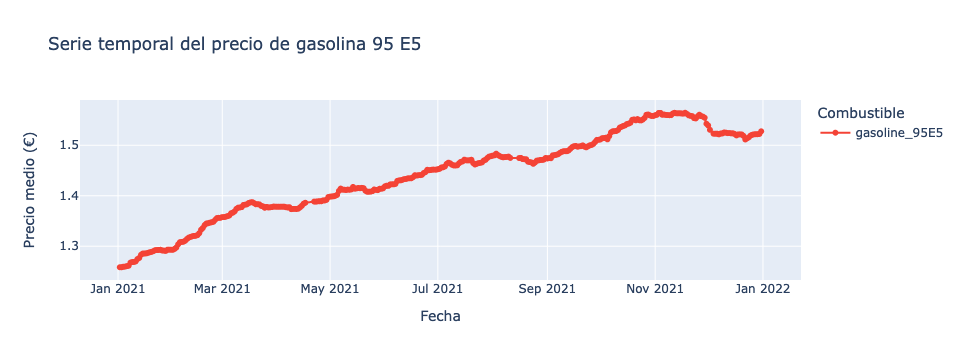

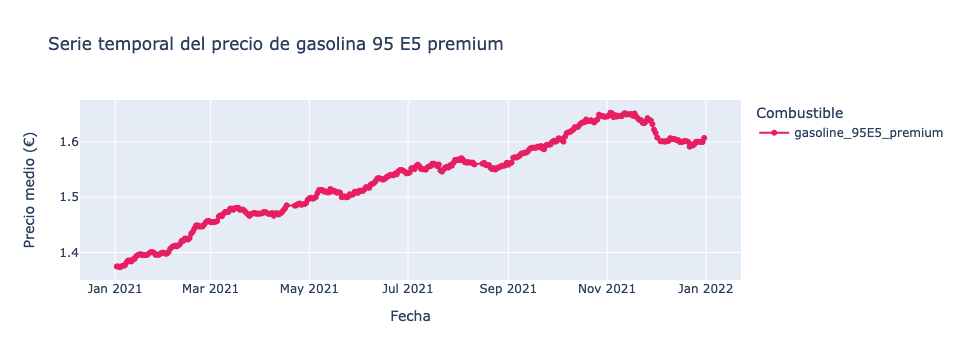

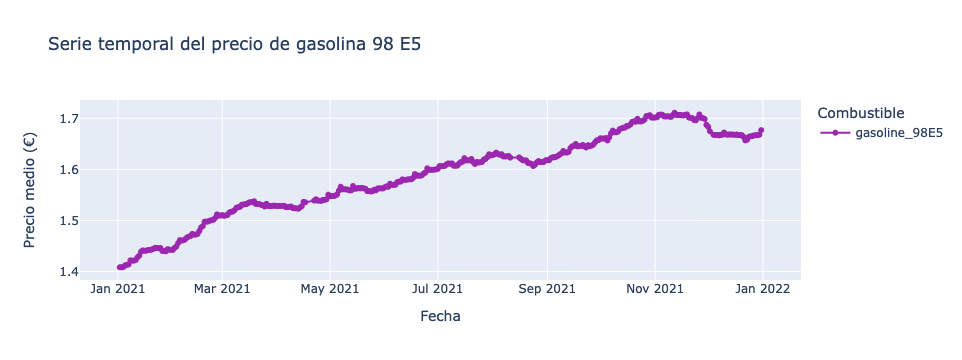

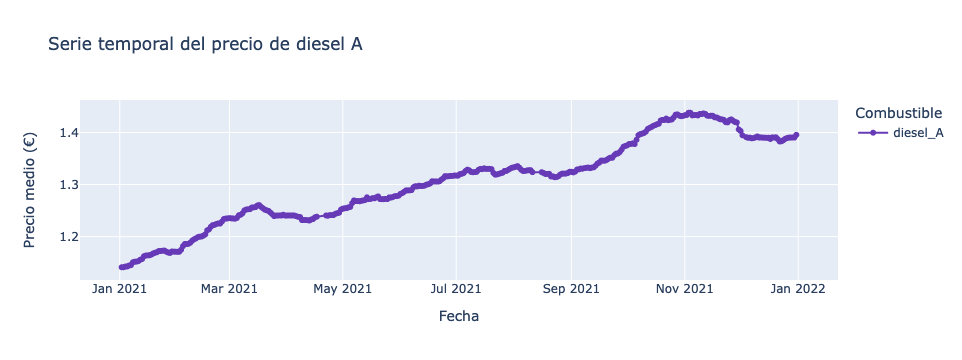

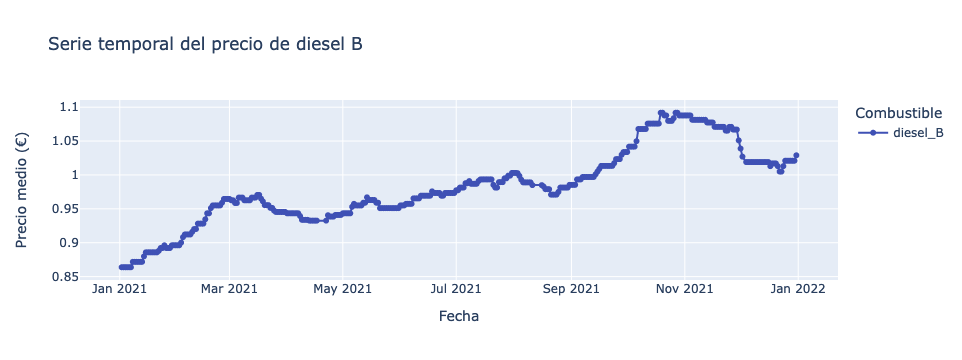

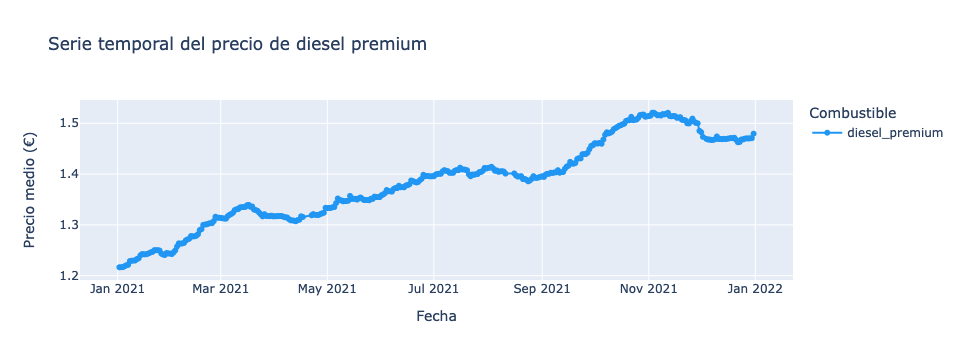

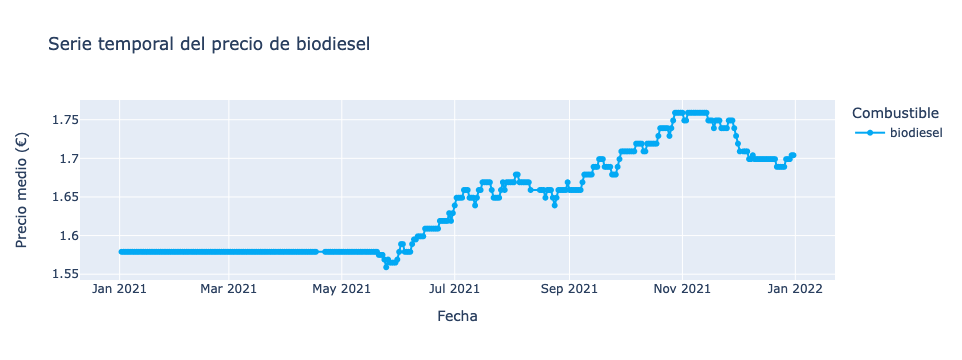

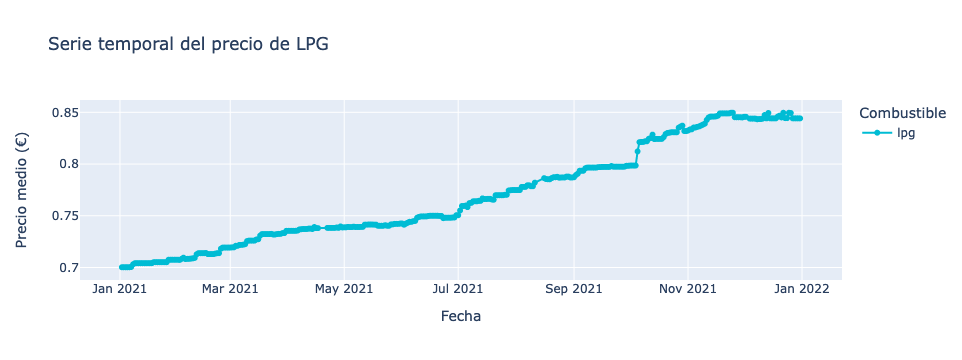

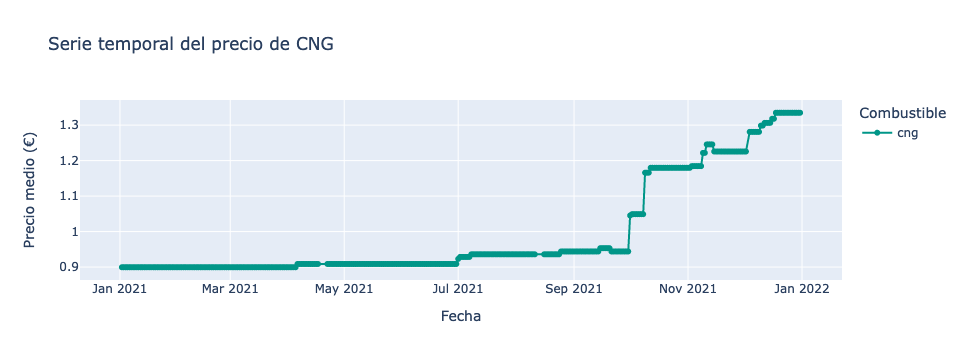

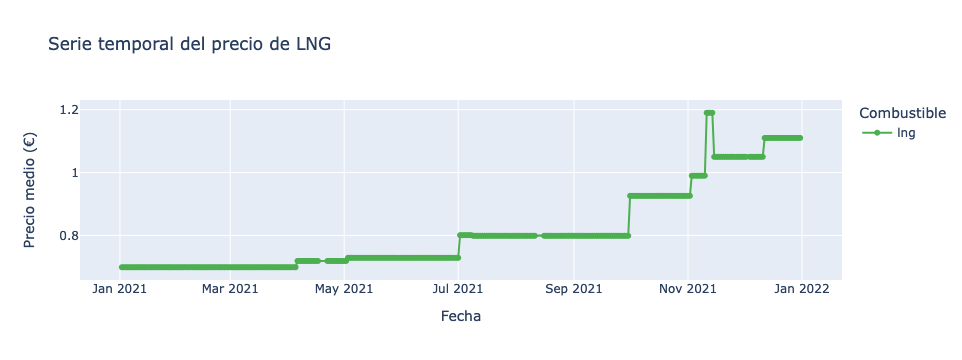

In [24]:
i=0
for product in products:
    df_lineas = dict_df_products[product][['date', product]]
    #Realizamos una media por fecha del precio del combustible en todas las gasolineras.
    df_lineas = df_lineas.groupby(['date'], group_keys = True).mean().reset_index() 

    fig = px.line(df_lineas, 
                  x = 'date', 
                  y = [product], 
                  color_discrete_sequence = [palette[i]], 
                  labels = {
                    "value": "Precio medio (€)",
                    "date": "Fecha",
                    "variable": "Combustible"
                  },
                  title = 'Serie temporal del precio de '+ products_titles[product])
    
    fig.update_traces(mode = "markers+lines", hovertemplate=None)
    fig.update_layout(hovermode = "x")
    
    fig.show()
    i=i+1


### Gráfico de líneas de la evolución de los precios de los combustibles

In [25]:
df_lineas = df_parsed[['date']+products].replace(0, np.nan)

df_lineas = df_lineas.groupby(['date'], group_keys=True).mean().reset_index()



### Gráfico de líneas de la comparativa entre precios ajustados y sin ajustar

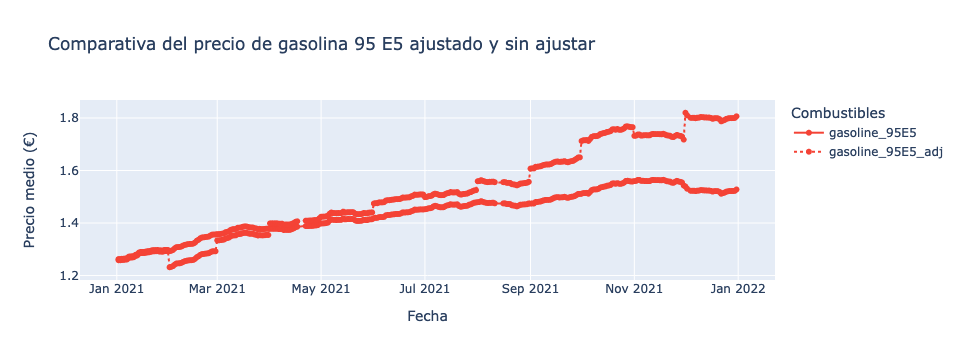

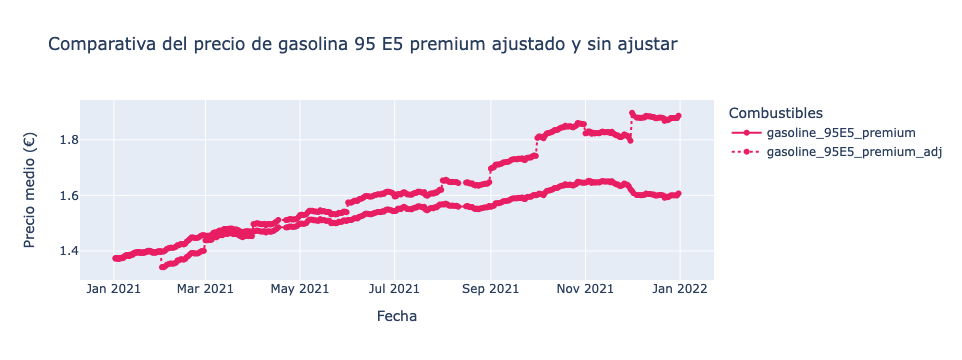

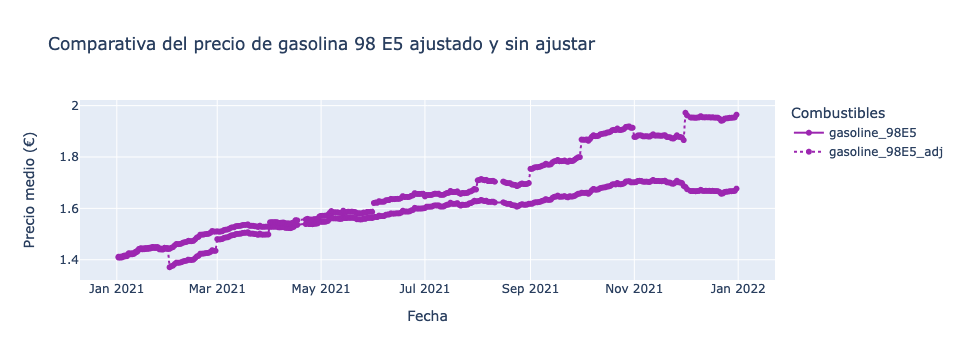

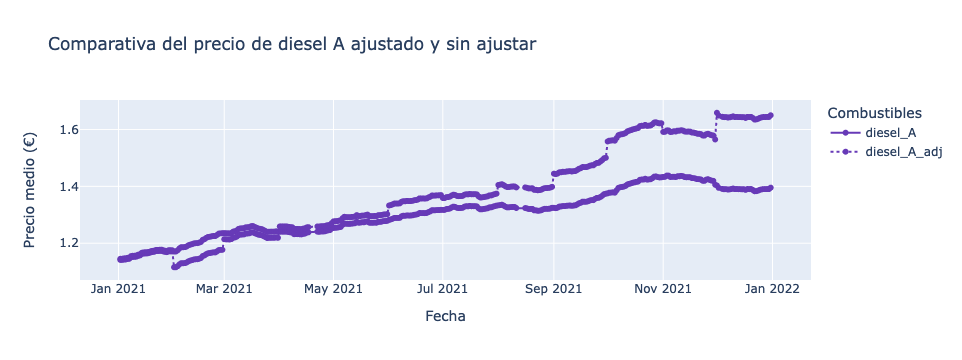

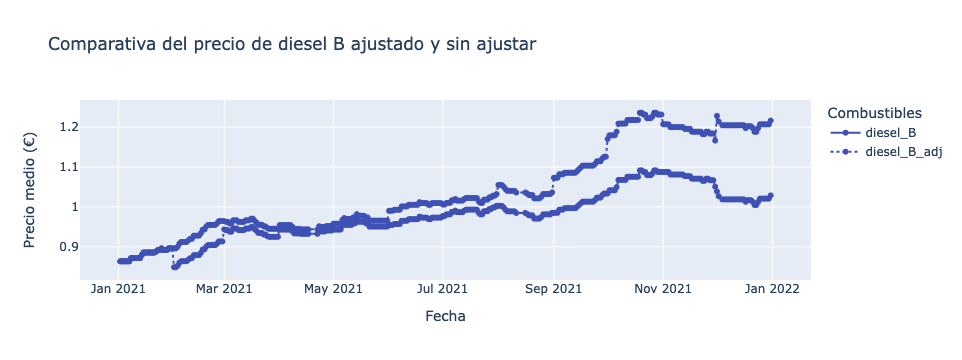

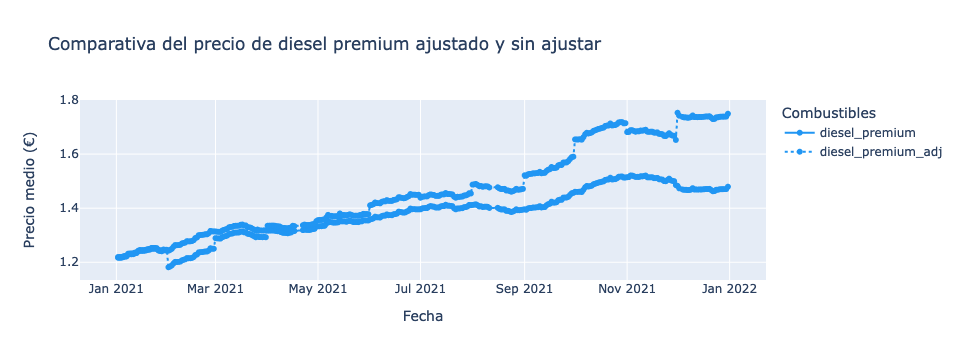

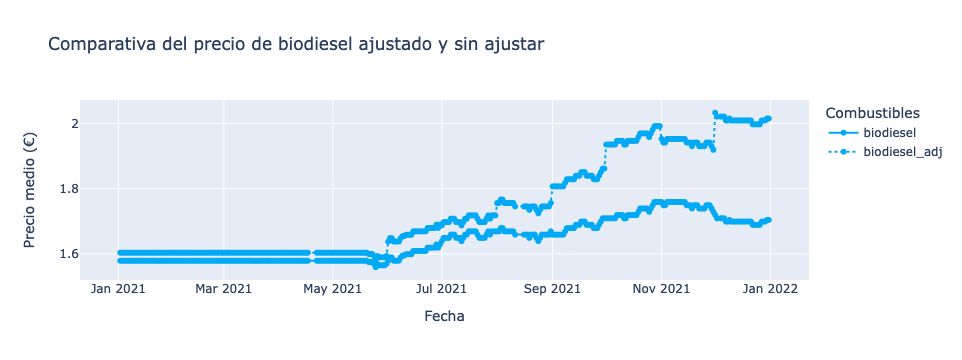

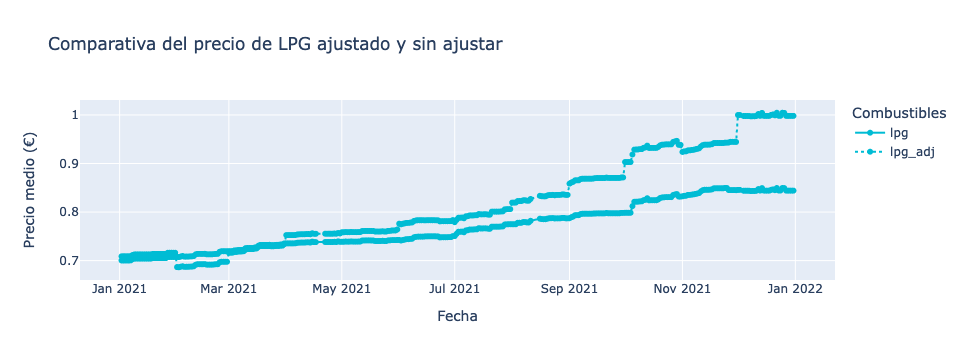

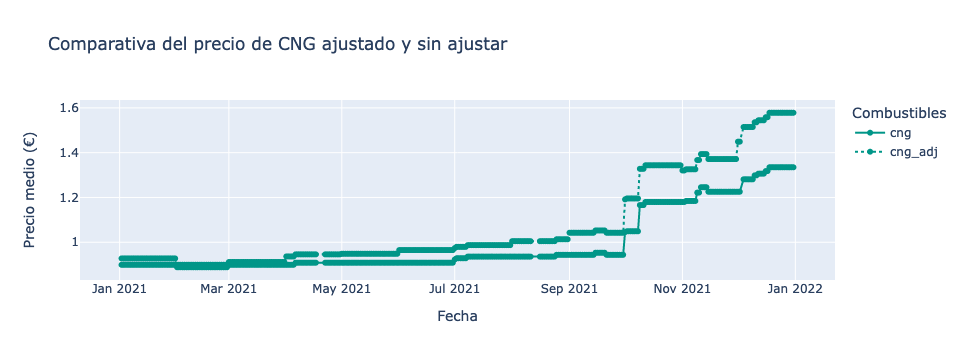

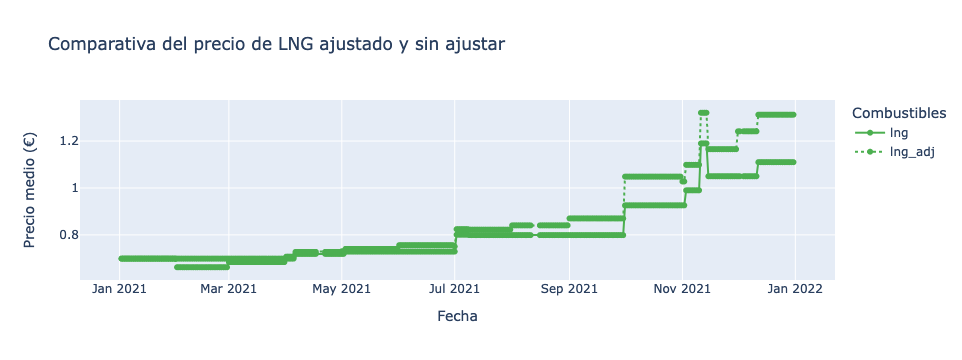

In [26]:

for i in range(len(products)):
    df_lineas = dict_df_products[products[i]][['date', products[i], products_adj[i]]]
    #Realizamos una media por fecha del precio del combustible en todas las gasolineras.
    df_lineas = df_lineas.groupby(['date'], group_keys = True).mean().reset_index()
    
    fig = px.line(df_lineas,
                  x='date', 
                  y=[products[i], products_adj[i]], 
                  labels={
                    "value": "Precio medio (€)",
                    "date": "Fecha",
                    "variable": "Combustibles"
                  },
                  title="Comparativa del precio de " + products_titles[products[i]] + " ajustado y sin ajustar",
                  color_discrete_sequence = [palette[i]])
        
    fig.update_traces(patch={"line": {"dash": 'dot'}}, selector={"legendgroup": products_adj[i]})
    fig.update_traces(mode="markers+lines", hovertemplate=None)
    fig.update_layout(hovermode="x unified")
    
    fig.show()



### Gráfico de lineas de la comparativa entre los precios ajustados de los combustibles

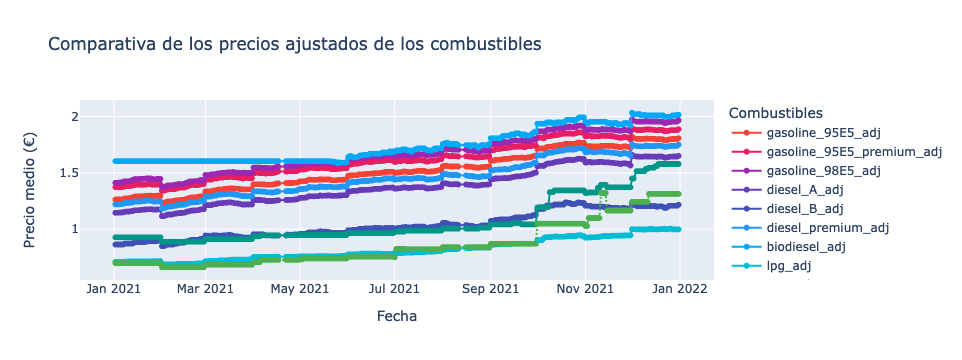

In [27]:
df_lineas = df_parsed[['date'] + products_adj].replace(0, np.nan)

df_lineas = df_lineas.groupby(['date'], group_keys = True).mean().reset_index()

fig = px.line(df_lineas, 
              x = 'date', 
              y = products_adj, 
              color_discrete_sequence = palette, 
              labels = {
                    "value": "Precio medio (€)",
                    "date": "Fecha",
                    "variable": "Combustibles"},
              title="Comparativa de los precios ajustados de los combustibles")

fig.update_traces(patch = {"line": {"dash": 'dot'}}, selector={"legendgroup": products_adj[i]})
fig.update_traces(mode = "markers+lines", hovertemplate=None)
fig.update_layout(hovermode = "x unified")

fig.show()

### Piechart del reparto de gasolineras por empresa

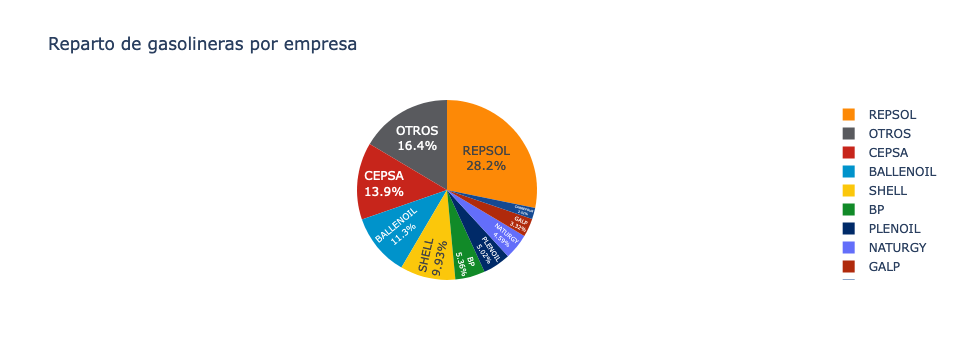

In [28]:
last_date=max(df_parsed['date'])
fig = px.pie(df_parsed[df_parsed['date'] == last_date], 
             values = 'station_id', 
             names = 'name_parsed', 
             title = 'Reparto de gasolineras por empresa', 
             color = 'name_parsed',
             labels = {'name_parsed':'Company',
                    'station_id':'Gasolineras'},
             color_discrete_map = name_colors)
fig.update_traces(textposition='inside', textinfo = 'percent+label')
fig.show()

In [29]:
# Adaptamos city border para marcar el contorno de la ciudad de Madrid
city_border['features'][0]['geometry'] = city_border['features'][0].copy()
city_border['features'][0]['type'] = "Feature"
city_border['features'][0]['id'] = "Madrid"
del city_border['features'][0]['coordinates']

### Mapa con la distribución de las gasolinearas por empresa

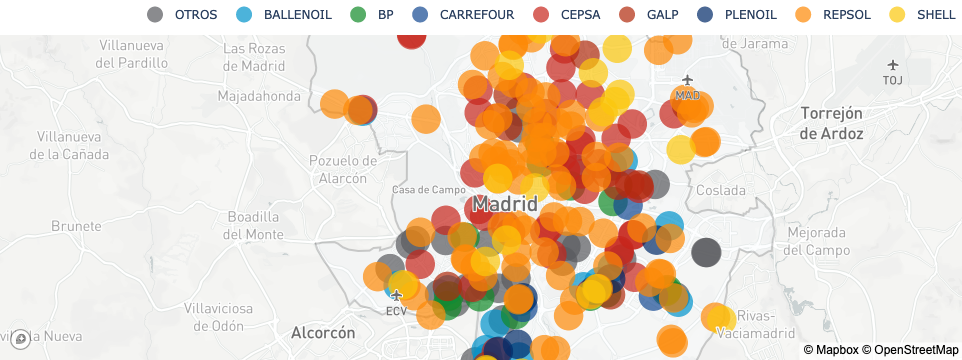

In [30]:
import plotly.graph_objects as go

#Hago copia para no cargarme el original
df_mapa = df_parsed.copy()

#Unicamente cogemos los datos para la primera fecha
df_mapa = df_mapa.sort_values(['station_id', 'date'], ascending=False).groupby('station_id', as_index=False).first() 

#Necesario para algunas funciones de Scattermapbox
mapbox_access_token = 'pk.eyJ1IjoiZWlzZW5oZXJyIiwiYSI6ImNsYXByaWNqajEzOHAzeG4wYTV6NDZ4aDIifQ.oGCZPVxl5y6Zyg8MJWTypQ'

fig = go.Figure()
fig.add_trace(go.Choroplethmapbox(geojson = city_border, locations=["Madrid"], 
                                    z = [0],
                                    colorscale = "Blues", 
                                    zmin = 0, 
                                    zmax = max(df_mapa.groupby("neighbourhood",as_index = False).count()['station_id']),
                                    showscale=False,
                                      marker_opacity = 0.25, 
                                    marker_line_width=2))

for name in list(name_colors.keys()):
    df_mapa_1 = df_mapa[df_mapa['name_parsed'] == name]
    fig.add_trace(go.Scattermapbox(
        name = name,
        mode = "markers+text",
        lat = df_mapa_1["latitude"], lon = df_mapa_1["longitude"],
        marker = go.scattermapbox.Marker(
                size = df_mapa['num_combustibles'] * 3,
                symbol = "circle",
                color = name_colors[name],
                opacity = 0.7)
        ))
      
fig.update_layout(mapbox_style = "open-street-map",
                  margin = {"r":0,"t":0,"l":0,"b":0},
                  mapbox = dict(accesstoken = mapbox_access_token,
                              center = dict(lat = 40.42, lon = -3.72),
                              style = 'light',
                              zoom = 10),
                 legend=dict(
                          orientation="h",
                          yanchor="bottom",
                          y=1.02,
                          xanchor="right",
                          x=1
                      ))

fig.show();



### Mapa con la densidad de gasolineras por barrio de Madrid

In [31]:
## Modificamos nuestro .geojson
for i in range(len(neighbourhood_borders['features'])):
    neighbourhood_borders['features'][i]['geometry']=neighbourhood_borders['features'][i].copy()
    neighbourhood_borders['features'][i]['type']="Feature"
    neighbourhood_borders['features'][i]['id']=neighbourhood_names.loc[i, 'Name']
    del neighbourhood_borders['features'][i]['coordinates']

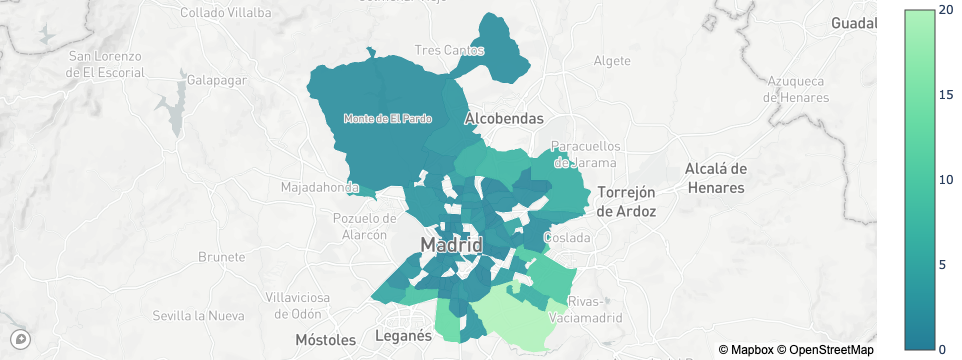

In [32]:
#Hago copia para no cargarme el original
df_mapa = df_parsed.copy()
#Voy a coger la ultima fecha de cada gasolinera para solo pintar un punto
df_mapa = df_mapa.sort_values(['station_id', 'date'], ascending = False).groupby('station_id', as_index = False).first()

fig = go.Figure(go.Choroplethmapbox(geojson=neighbourhood_borders, locations=np.sort(df_mapa.neighbourhood.unique()), 
                                    z = df_mapa.groupby("neighbourhood",as_index = False).count()['station_id'],
                                    colorscale = "tealgrn_r", 
                                    zmin = 0, 
                                    zmax = max(df_mapa.groupby("neighbourhood",as_index = False).count()['station_id']),
                                    marker_opacity = 0.9, marker_line_width=0))

fig.update_layout(mapbox_style = "open-street-map",
                  margin = {"r":0,"t":0,"l":0,"b":0},
                  mapbox = dict(accesstoken = mapbox_access_token,
                              center=dict(lat=40.48, lon = -3.72),
                              style = 'light',
                              zoom = 9.1))
fig.show();

### Gráfico de violin con el precio de los combustibles.

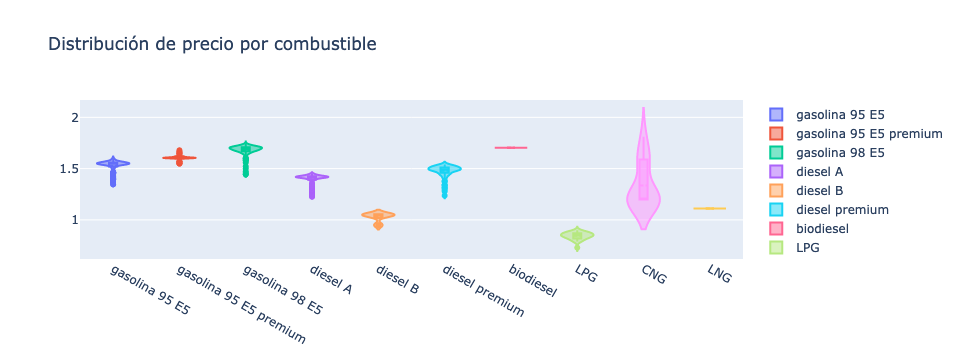

In [36]:
df_violin = df_parsed.copy()
df_violin = df_violin.replace(0, np.nan)
df_violin = df_violin.sort_values(['station_id', 'date'], ascending = False).groupby('station_id', as_index = False).first()
df_violin = df_violin[['date'] + products]

fig = go.Figure()

for product in products:
    fig.add_trace(go.Violin(y = df_violin[product],
                            name = products_titles[product],
                            box_visible = True,
                            meanline_visible = True ))

fig.update_layout(title_text="Distribución de precio por combustible", yaxis_zeroline=True)
fig.show()


### Gráfico de violin con el precio del combustible por empresa.

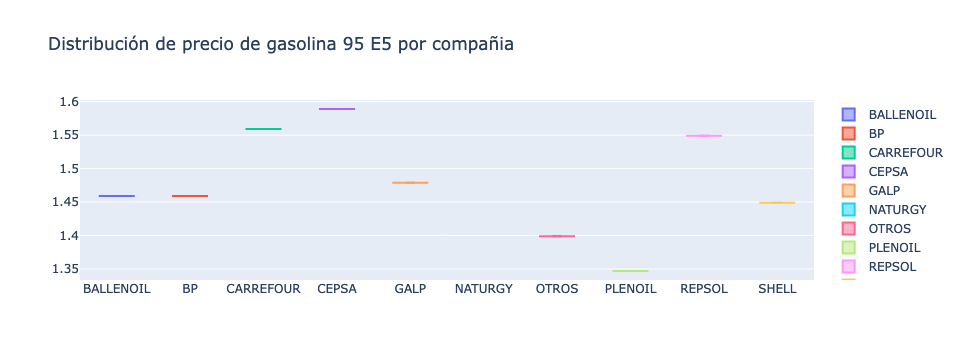

In [37]:
product = products[0]
df_violin = df_parsed.copy()

df_violin = df_violin.replace(0, np.nan)
df_violin = df_violin.sort_values(['station_id', 'date'], ascending = False).groupby('name_parsed', as_index = False).first()
df_violin = df_violin[['date'] + products + ['name_parsed']]


fig = go.Figure()

for company in df_violin['name_parsed']:
    fig.add_trace(go.Violin(
                            y = df_violin[df_violin['name_parsed']==company][product],
                            name = company,
                            box_visible = True,
                            meanline_visible = True ))
fig.update_layout(title_text="Distribución de precio de " + products_titles[product] + " por compañia", yaxis_zeroline=True)
fig.show()

### Scatter-plot precio del combustible en función de la distancia a la gasolinera más cercana

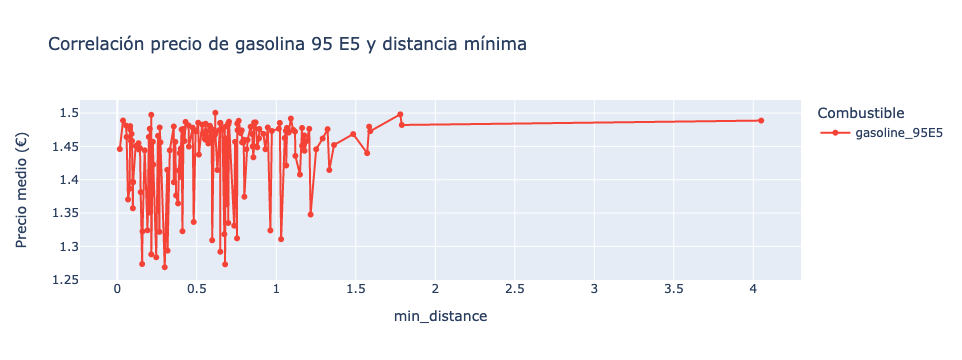

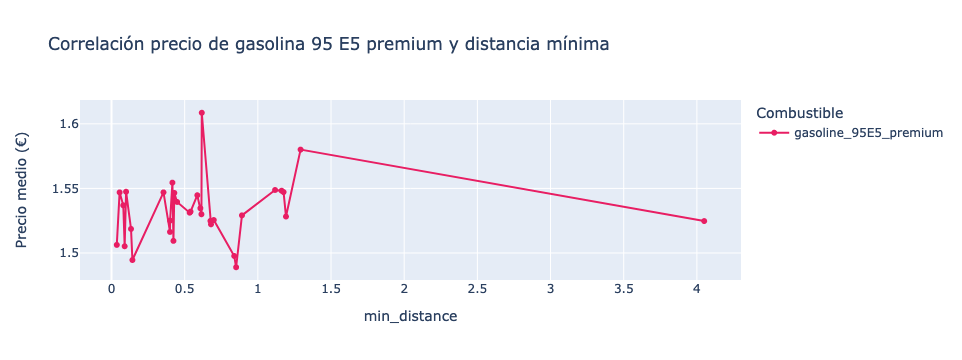

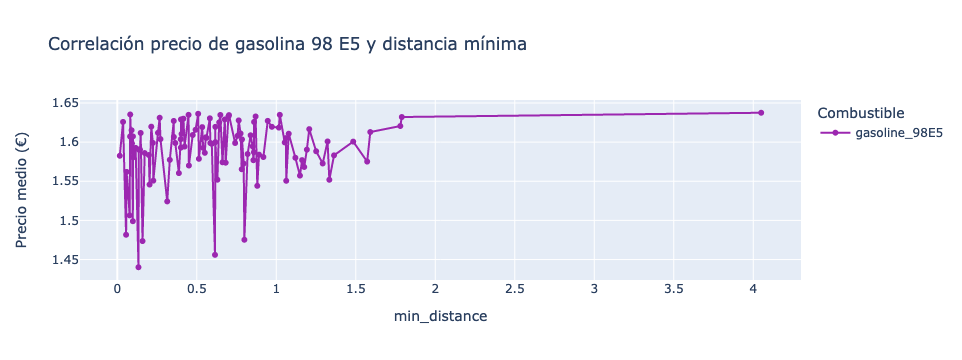

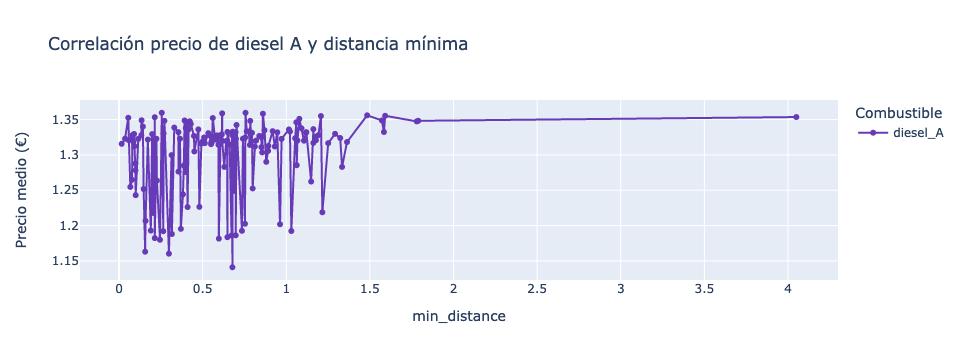

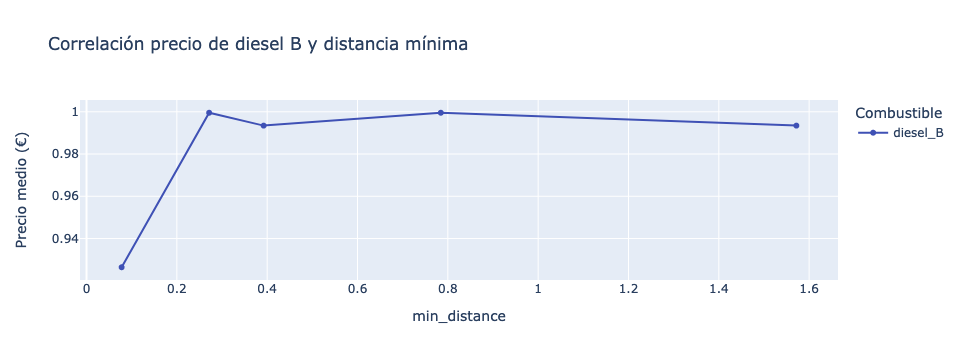

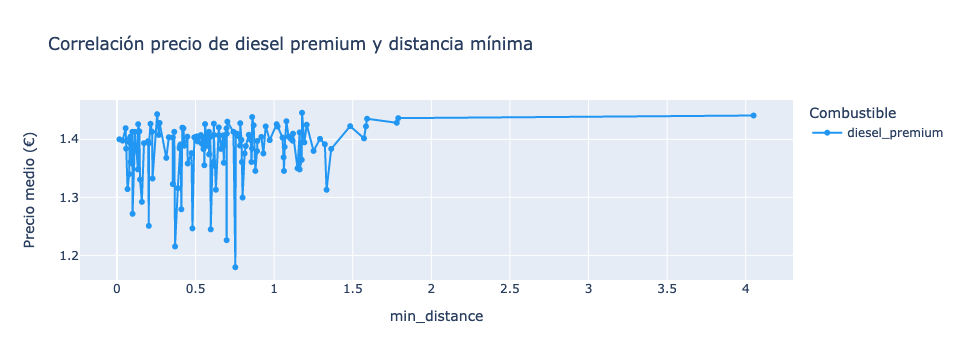

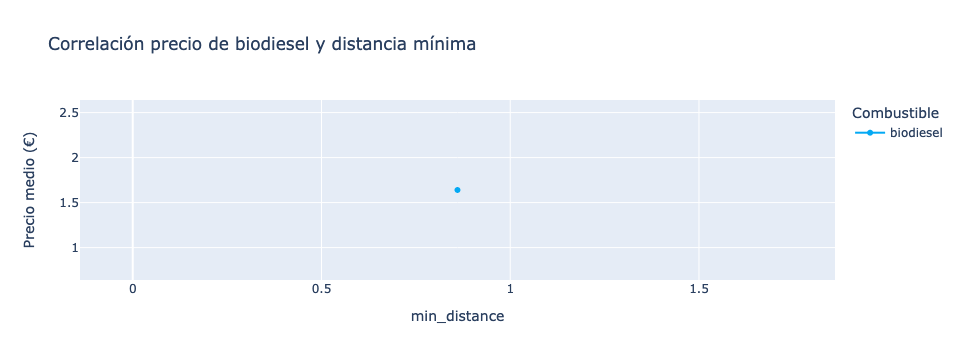

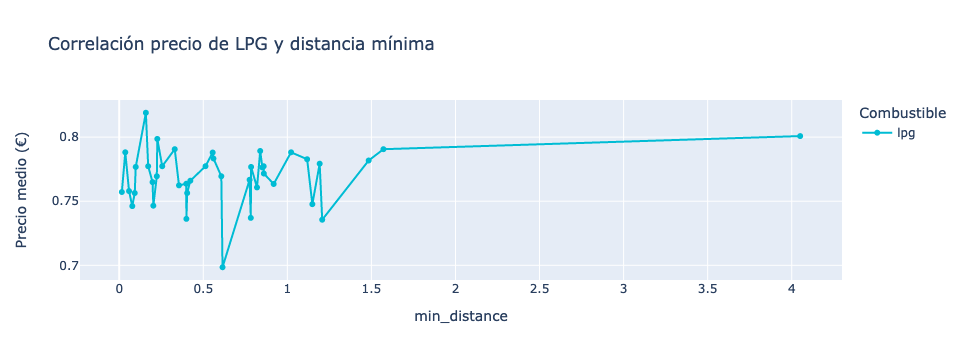

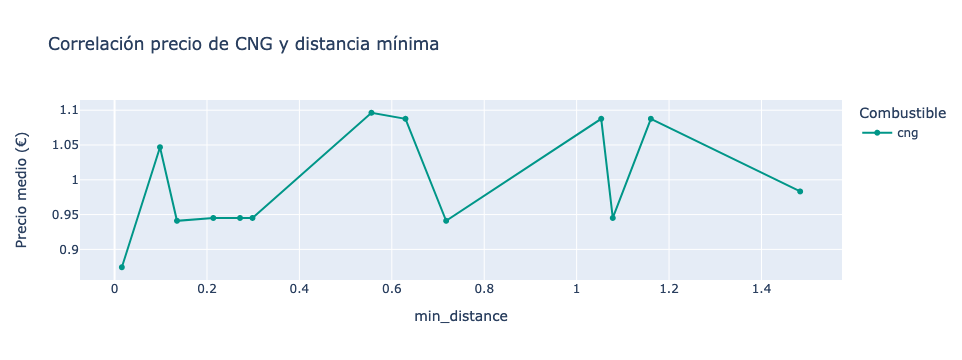

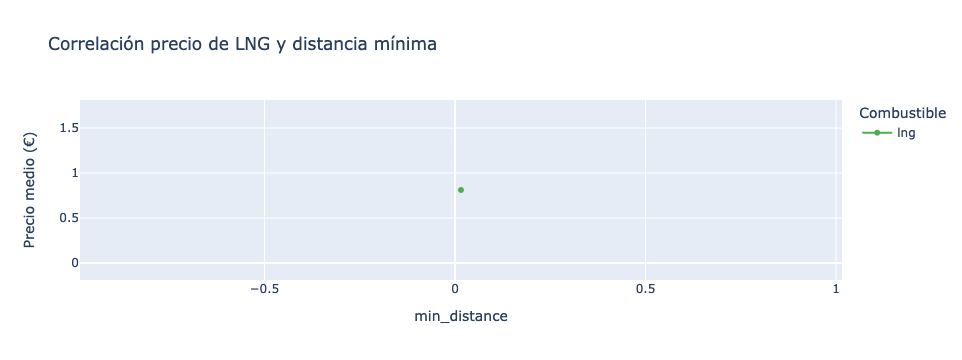

In [38]:
i=0
for product in products:
    df_lineas = dict_df_products[product][['min_distance', product]]
    #Realizamos una media por fecha del precio del combustible en todas las gasolineras.
    df_lineas = df_lineas.groupby(['min_distance'], group_keys = True).mean().reset_index() 

    fig = px.line(df_lineas, 
                  x = 'min_distance', 
                  y = [product], 
                  color_discrete_sequence = [palette[i]], 
                  labels = {
                    "value": "Precio medio (€)",
                    "date": "Distancia Mínima",
                    "variable": "Combustible"
                  },
                  title = 'Correlación precio de '+ products_titles[product] + ' y distancia mínima')
    
    fig.update_traces(mode = "markers+lines", hovertemplate=None)
    fig.update_layout(hovermode = "x")
    
    fig.show()
    i=i+1


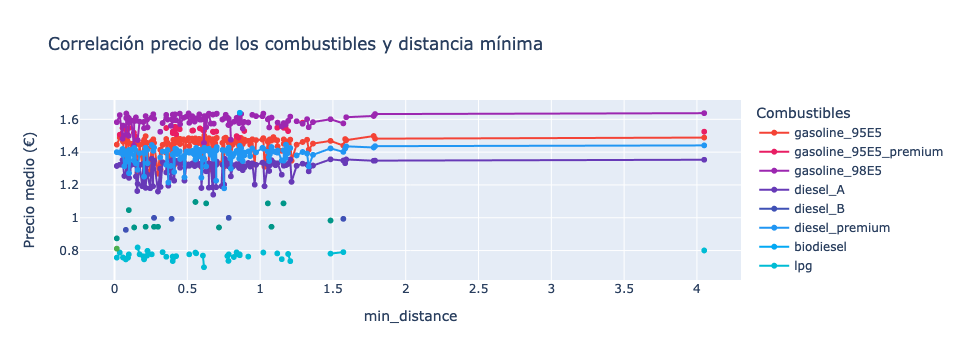

In [39]:
df_lineas = df_parsed[['min_distance'] + products].replace(0, np.nan)

df_lineas = df_lineas.groupby(['min_distance'], group_keys = True).mean().reset_index()

fig = px.line(df_lineas, 
              x='min_distance', 
              y= products, 
              color_discrete_sequence = palette, 
              labels={
                    "value": "Precio medio (€)",
                    "date": "Fecha",
                    "variable": "Combustibles"
                  },
              title="Correlación precio de los combustibles y distancia mínima")

fig.update_traces(mode="markers+lines", hovertemplate=None)
fig.update_layout(hovermode="x unified")

fig.show()